Target distribution:
target
0.0    789400
1.0     10600
Name: count, dtype: int64
y_train distribution:
target
1.0    8498
0.0    8462
Name: count, dtype: int64
Starting Randomized Search...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters:  {'xgb__colsample_bytree': 0.9027996528688915, 'xgb__gamma': 0.2344823389560996, 'xgb__learning_rate': 0.06373449640506147, 'xgb__max_depth': 9, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 281, 'xgb__reg_alpha': 0.7723183917356393, 'xgb__reg_lambda': 0.5201635011119934, 'xgb__subsample': 0.940872600127416}
Prediction results saved to predicted_results_xgboost_stacking.xlsx
Classification report on test set:
               precision    recall  f1-score   support

         0.0       0.87      0.83      0.85      2138
         1.0       0.83      0.87      0.85      2102

    accuracy                           0.85      4240
   macro avg       0.85      0.85      0.85      4240
weighted avg       0.85      0.85      0

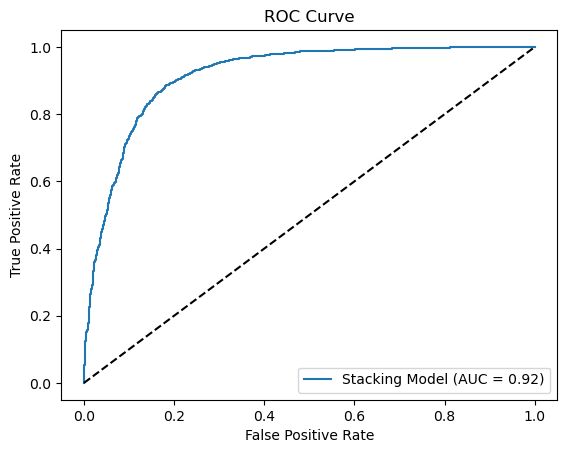

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, randint

# Record start time
start_time = time.time()

# Load dataset
data = pd.read_csv('train.csv')

# Check the distribution of the target variable
print("Target distribution:")
print(data['target'].value_counts())

# Extract positive and negative samples
positive_samples = data[data['target'] == 1]
negative_samples = data[data['target'] == 0]

# Balance the dataset by upsampling the minority class
minority_class = positive_samples
majority_class = negative_samples.sample(n=len(positive_samples), replace=True, random_state=42)
balanced_data = pd.concat([majority_class, minority_class])

# Feature combinations
# Example of creating feature combinations
balanced_data['feature_comb1'] = balanced_data['cat_0'] * balanced_data['num_0']
balanced_data['feature_comb2'] = balanced_data['cat_1'] + balanced_data['num_1']
balanced_data['feature_comb3'] = balanced_data['cat_2'] / (balanced_data['num_2'] + 1)

# Split the dataset into features (X) and target (y)
X = balanced_data.drop(['id', 'target'], axis=1)
y = balanced_data['target']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the distribution of y_train
print("y_train distribution:")
print(y_train.value_counts())

# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define the Stacking model
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression()
)

# Define the parameter distribution for Randomized Search
param_dist = {
    'xgb__n_estimators': randint(100, 300),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__gamma': uniform(0, 5),
    'xgb__reg_alpha': uniform(0, 1),
    'xgb__reg_lambda': uniform(0, 1)
}

# Perform Randomized Search to optimize the Stacking model
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=stacking_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of iterations
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters: ", random_search.best_params_)

# Train the model with the best parameters
best_model = random_search.best_estimator_

# Predict probabilities for unknown users
unknown_users = data[data['target'] == 0].drop(['id', 'target'], axis=1)
unknown_users['feature_comb1'] = unknown_users['cat_0'] * unknown_users['num_0']
unknown_users['feature_comb2'] = unknown_users['cat_1'] + unknown_users['num_1']
unknown_users['feature_comb3'] = unknown_users['cat_2'] / (unknown_users['num_2'] + 1)
unknown_users_scaled = scaler.transform(unknown_users)
predicted_probabilities = best_model.predict_proba(unknown_users_scaled)[:, 1]  # Get the probabilities for being a 5G user

# Set a threshold to determine which users are likely 5G users
threshold = 0.5  # This threshold can be adjusted
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Save the results
results = pd.DataFrame({
    'id': data[data['target'] == 0]['id'],
    'predicted_target': predicted_labels
})
results.to_excel('predicted_results_xgboost_stacking.xlsx', index=False)

print("Prediction results saved to predicted_results_xgboost_stacking.xlsx")

# Evaluate the model performance on the test set
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_prob > threshold).astype(int)
print("Classification report on test set:\n", classification_report(y_test, y_test_pred))
auc_score = roc_auc_score(y_test, y_test_pred_prob)
print("Test set AUC score:", auc_score)

# Record end time and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Code run time: {elapsed_time:.2f} seconds")

# Plot the ROC curve for the best model
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'Stacking Model (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()